##Preliminary actions

Before running the cells below you need to download the dataset from https://www.kaggle.com/xainano/handwrittenmathsymbols

Extract files from 'archive.zip' and upload the 'data.rar' using cell below

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving data.rar to data.rar


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.transforms.functional as TF
import time
import os

In [ ]:
os.mkdir('/content/data')

In [ ]:
!pip install pyunpack
!pip install patool
from pyunpack import Archive
Archive('/content/data.rar').extractall('/content/data')

     |████████████████████████████████| 81kB 5.6MB/s 


##Hyperparameters

In [ ]:
#hyperparameters
batch_size = 64
epochCount = 20
learningRate = 0.0005
batchrow = int(batch_size / 8)

##Preparation and overview of dataset

In [ ]:
# import the handwrittenmathsymbols set using the ImageFolder dataset class
dataset_util = torchvision.datasets.ImageFolder(root='/content/data/extracted_images', transform=transforms.ToTensor())

# dataloaders "represent a Python iterable over a dataset"
dataloader = torch.utils.data.DataLoader(dataset_util, batch_size=batch_size, num_workers=2, shuffle=True)

In [ ]:
iter_test = iter(dataloader)
img, lbl = iter_test.next()
display(img[0], lbl)

tensor([[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.9961],
         [1.0000, 1.0000, 1.0000,  ..., 0.9961, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 0.9882, 1.0000, 0.9922]],

        [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.9961],
         [1.0000, 1.0000, 1.0000,  ..., 0.9961, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 0.9882, 1.0000, 0.9922]],

        [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.

tensor([27, 21, 10, 60, 27,  8, 27,  2, 73,  8,  2,  7, 34, 67,  2,  6, 16, 34,
         7,  7,  8,  8, 11, 16, 10, 11,  5,  3,  7, 78, 32, 49,  5,  5, 17,  7,
        35, 72, 78,  2, 39,  1,  8,  8, 53,  9, 69, 56, 23, 79, 16, 27, 78,  8,
        56,  8, 27,  9, 10, 16, 27, 70,  2, 23])

In [ ]:
mean = 0.
std = 0.

for batch_idx, data in enumerate(dataloader, 0):
    image, label = data
    batchSize = image.size(0)
    image = image.view(batchSize, image.size(1), -1)
    mean += image.mean(2).sum(0)
    std += image.std(2).sum(0)
  
mean /= len(dataset_util)
std /= len(dataset_util)
print(mean, std)

tensor([0.9563, 0.9563, 0.9563]) tensor([0.1990, 0.1990, 0.1990])


In [ ]:
# taken from https://stackoverflow.com/a/56512552
def imshow(image, ax=None):
  """Imshow for Tensor."""
  if ax is None:
      fig, ax = plt.subplots()
  image = image.numpy().transpose((1, 2, 0))

  ax.imshow(image)
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.spines['left'].set_visible(False)
  ax.spines['bottom'].set_visible(False)
  ax.tick_params(axis='both', length=0)
  ax.set_xticklabels('')
  ax.set_yticklabels('')

  return ax

In [ ]:
classes = ('!','(',')','+',',','-','0','1','2','3','4','5','6','7','8','9',
           '=','A','C','Delta','G','H','M','N','R','S','T','X','[',']','alpha',
           'ascii_24','b','beta','cos','d','div','e','exists','f','forall',
           'forward_slash','gamma','geq','gt','i','in','infty','int','j','k',
           'l','lambda','ldots','leq','lim','log','lt','mu','neq','o','p',
           'phi','pi','pm','prime','q','rightarrow','sigma','sin','sqrt','sum',
           'tan','theta','times','u','v','w','y','z','{','}')
#some comments on classes:

#ascii 124 --- '|'
#div --- '%' or '/' or ':'
#forward_slash --- '/'
#geq --- '>='
#leq --- '<='
#neq --- '!='
#gt --- '>'
#lt --- '<'
#pm --- '+-'
#int --- integration symbol
#ldots --- '...'
#prime --- ???
#forall, exists, in --- mathematical logic, set theory

In [ ]:
classlen = len(classes)
classlen

82

    +	    A	    T	  sum	    ]	    -	    1	    T

    2	    )	    y	    )	    0	    1	    -	    H

    1	    (	    N	    z	    k	    +	    X	    2

    1	  log	    y	    +	   pi	    X	    N	  cos

    q	    N	    e	    3	    X	  sum	    f	    3

    (	  neq	    6	    +	    +	    1	    2	    )

    e	    d	    =	    X	    X	ascii_24	    ,	    2

    +	  sin	    y	    b	    1	    N	    y	  log



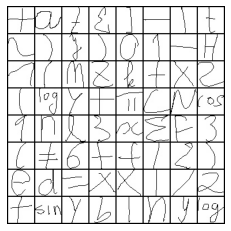

In [ ]:
# show grid of images from dataset
images, labels = next(iter(dataloader))

imshow(torchvision.utils.make_grid(images, nrow=8))

for k in range(batchrow):
  print('\t'.join('%5s' % classes[labels[j]] for j in range(8 * k, 8 * k + 8)),end='\n\n')
  k += 1

In [ ]:
datalen = len(dataset_util)
print(datalen)

375974


In [ ]:
mean, std

(tensor([0.9563, 0.9563, 0.9563]), tensor([0.1990, 0.1990, 0.1990]))

In [ ]:
dataset = torchvision.datasets.ImageFolder(root='/content/data/extracted_images', transform=
                                           transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean, std)]))
trainlen = int(datalen * 0.6)
evallen = datalen - trainlen

trainset, evalset = torch.utils.data.random_split(dataset, [trainlen, evallen])
vallen = int(evallen / 2)
testlen = evallen - vallen

valset, testset  = torch.utils.data.random_split(evalset, [vallen, testlen])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=int(batch_size / 3), shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=int(batch_size / 3), shuffle=False, num_workers=2)

In [ ]:
print(len(trainset))
print(len(valset))
print(len(testset))

225584
75195
75195


In [ ]:
image,_ = iter(trainloader).next()
image.size()

torch.Size([64, 3, 45, 45])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


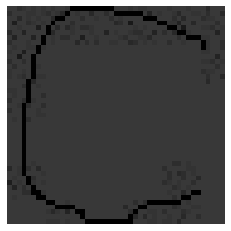

In [ ]:
imshow(image[0])

In [ ]:
print(len(trainset))
print(len(valset))
print(len(testset))
epoch_count_train = int(len(trainset) / batch_size)
epoch_count_val = int(5 * len(valset) / batch_size)
print(epoch_count_train)
print(epoch_count_val)

225584
75195
75195
3524
5874


##Model initialization

In [ ]:
class skynet3(nn.Module):
  def __init__(self):
    super(skynet3, self).__init__()

    self.conv1 = nn.Conv2d(3, 8, 3) # input, output, kernel
    self.conv2 = nn.Conv2d(8, 16, 3)
    self.conv3 = nn.Conv2d(16, 32, 3)
    self.conv4 = nn.Conv2d(32, 128, 4)

    self.pool1 = nn.MaxPool2d(2, 2, 1) #kernel, stride, padding
    self.pool2 = nn.MaxPool2d(2, 2)
    self.pool3 = nn.MaxPool2d(2, 2)

    self.fc1 = nn.Linear(128, 128)
    self.fc2 = nn.Linear(128, 82)

    torch.nn.init.xavier_uniform_(self.conv1.weight)
    torch.nn.init.xavier_uniform_(self.conv2.weight)
    torch.nn.init.xavier_uniform_(self.conv3.weight)
    torch.nn.init.xavier_uniform_(self.conv4.weight)
    torch.nn.init.xavier_uniform_(self.fc1.weight)
    torch.nn.init.xavier_uniform_(self.fc2.weight)
    
  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.pool1(x)
    x = F.relu(self.conv2(x))
    x = self.pool2(x)
    x = F.relu(self.conv3(x))
    x = self.pool3(x)
    x = F.relu(self.conv4(x))
    x = x.view(-1, 128)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    return x

net = skynet3()

In [ ]:
net

skynet3(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(32, 128, kernel_size=(4, 4), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=128, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=82, bias=True)
)

In [ ]:
params = list(net.parameters())
print(len(params))
for i in range(10):
  print(params[i].size())

12
torch.Size([8, 3, 3, 3])
torch.Size([8])
torch.Size([16, 8, 3, 3])
torch.Size([16])
torch.Size([32, 16, 3, 3])
torch.Size([32])
torch.Size([128, 32, 4, 4])
torch.Size([128])
torch.Size([128, 128])
torch.Size([128])


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params, lr = learningRate, betas = (0.9,0.999), eps = 1e-6)

##Model training

In [ ]:
tloss_plt = []
train_acc_plot = []
correct_train = 0.0
total_train = 0.0

vloss_plt = []
val_acc_plot = []
correct_val = 0.0
total_val = 0.0


for epoch in range(epochCount):

    running_tloss = 0.0
    running_vloss = 0.0
    avg_perbatch_acc_train = 0.0
    avg_perbatch_acc_val = 0.0
    start = time.time()

    print('epoch', epoch + 1)

    net.train(mode=True)
    print('training cycle')
    for i, data in enumerate(trainloader, 0):
      inputs, labels = data

      optimizer.zero_grad()

      outputs = net(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      perbatch_acc_train = 0.0
      _, predicted_train = torch.max(outputs.data, 1)
      total_train += labels.size(0)
      correct_train += (predicted_train == labels).sum().item()
      perbatch_acc_train = correct_train / total_train
      avg_perbatch_acc_train += perbatch_acc_train / 2 # 100 * accuracy / 200

      running_tloss += loss.item()

      if i % 50 == 49:
         tloss_plt.append(loss.item())
         
      if i % 200 == 199:
        print('[%d, %5d] train loss: %.6f, avg_train_acc: %.2f %%' % (epoch + 1, i + 1, running_tloss / 200, avg_perbatch_acc_train))
        train_acc_plot.append(avg_perbatch_acc_train)
        running_tloss = 0.0
        avg_perbatch_acc_train = 0.0

    net.train(mode=False)
    print('evaluation cycle')
    with torch.no_grad():
      for i, data in enumerate(valloader, 0):
        inputs, labels = data

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        
        perbatch_acc_val = 0.0
        _, predicted_val = torch.max(outputs.data, 1)
        total_val += labels.size(0)
        correct_val += (predicted_val == labels).sum().item()
        perbatch_acc_val = correct_val / total_val
        avg_perbatch_acc_val += perbatch_acc_val / 2

        running_vloss += loss.item()

        if i % 50 == 49:
         vloss_plt.append(loss.item())
         
        if i % 200 == 199:
          print('[%d, %5d] val loss: %.6f, avg_val_acc: %.2f %%' % (epoch + 1, i + 1, running_vloss / 200, avg_perbatch_acc_val))
          val_acc_plot.append(avg_perbatch_acc_val)
          running_vloss = 0.0
          avg_perbatch_acc_val = 0.0

    end = time.time()
    print('time spent on epoch %d: %.2f s' % (epoch + 1,end - start))
print('sector clear!')

epoch 1
training cycle
[1,   200] train loss: 2.164897, avg_train_acc: 35.50 %
[1,   400] train loss: 0.981128, avg_train_acc: 57.81 %
[1,   600] train loss: 0.702276, avg_train_acc: 66.19 %
[1,   800] train loss: 0.593354, avg_train_acc: 70.87 %
[1,  1000] train loss: 0.523619, avg_train_acc: 74.06 %
[1,  1200] train loss: 0.474543, avg_train_acc: 76.25 %
[1,  1400] train loss: 0.426697, avg_train_acc: 77.92 %
[1,  1600] train loss: 0.396483, avg_train_acc: 79.34 %
[1,  1800] train loss: 0.389670, avg_train_acc: 80.46 %
[1,  2000] train loss: 0.363730, avg_train_acc: 81.40 %
[1,  2200] train loss: 0.358356, avg_train_acc: 82.20 %
[1,  2400] train loss: 0.353954, avg_train_acc: 82.84 %
[1,  2600] train loss: 0.338916, avg_train_acc: 83.39 %
[1,  2800] train loss: 0.306305, avg_train_acc: 83.93 %
[1,  3000] train loss: 0.299448, avg_train_acc: 84.42 %
[1,  3200] train loss: 0.287650, avg_train_acc: 84.88 %
[1,  3400] train loss: 0.294532, avg_train_acc: 85.26 %
evaluation cycle
[1,   20

## Saving Model

In [ ]:
torch.save(net, '/content/model.pth')

In [ ]:
from google.colab import files
files.download('/content/model.pth') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
net = torch.load('/content/model.pth')

or

In [ ]:
torch.save(net.state_dict(), '/content/model_state_dict.pth')

In [ ]:
net = skynet3()
net.load_state_dict(torch.load('/content/model_state_dict.pth'))

<All keys matched successfully>

##Post-training analysis

20 13


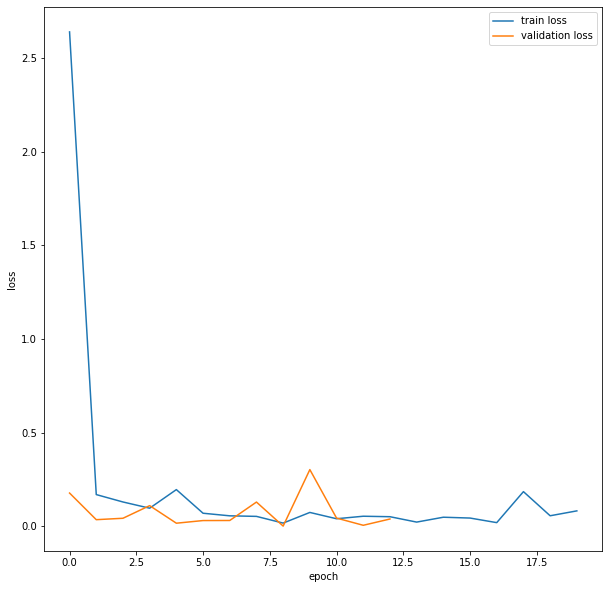

In [ ]:
tloss_plt_epoch = tloss_plt[0::int(epoch_count_train / 50)]
vloss_plt_epoch = vloss_plt[0::int(epoch_count_val / 50)]
print(len(tloss_plt_epoch), len(vloss_plt_epoch))
plt.figure(figsize=[10, 10])
plt.plot(tloss_plt_epoch,label='train loss')
plt.plot(vloss_plt_epoch,label='validation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='upper right')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ground truth labels:
    i	    j	    +	    +	    +	    0	  leq	    -

    =	    +	   pi	    -	    4	  tan	  log	    X

    2	    -	    +	   pi	    T	    +	    e	  sin

    (	times	    -	    0	    -	    R	    (	    N

    3	    N	    -	    -	    i	    1	    2	    e

    )	 sqrt	theta	 sqrt	    z	    -	    A	    -

    -	    =	    )	    9	    X	    5	    X	    8

  int	    )	    5	    1	    T	    k	    X	    -

predicted:
    i	    j	    +	    +	    +	    0	  leq	    -

    =	    +	   pi	    -	    4	  tan	  log	    X

    2	    -	    +	   pi	    T	    +	    e	  sin

    (	times	    -	    0	    -	    R	    (	    N

    3	    N	    -	    -	    i	    1	    2	    e

    )	 sqrt	theta	 sqrt	    z	    -	    A	    -

    -	    =	    )	    9	    X	    5	    X	    8

  int	    )	    5	    1	    T	    k	    X	    -



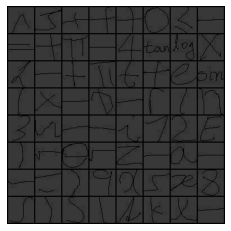

In [ ]:
valloader_prediction = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=True, num_workers=2)

dataiter = iter(valloader_prediction)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print('ground truth labels:')
for k in range(batchrow):
  print('\t'.join('%5s' % classes[labels[j]] for j in range(k * 8, (k + 1) * 8)),end='\n\n')
  k += 1

outputs = net(images)

_,predicted = torch.max(outputs, 1)
print('predicted:')
for k in range(batchrow):
  print('\t'.join('%5s' % classes[predicted[j]] for j in range(k * 8, (k + 1) * 8)),end='\n\n')
  k += 1

340 340


Text(0, 0.5, 'accuracy,%')

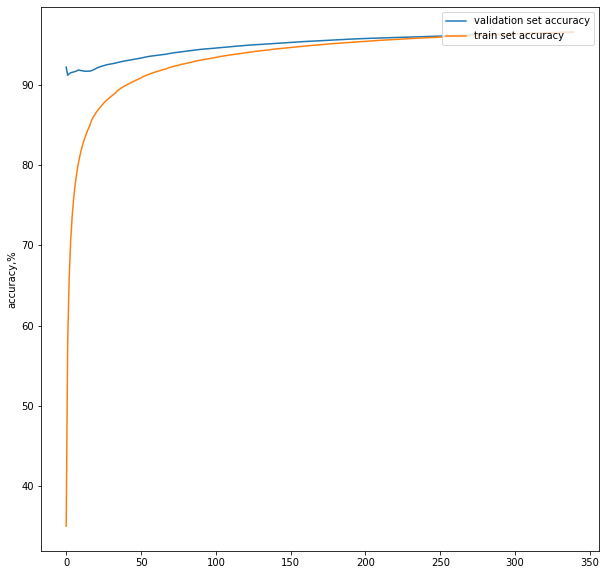

In [ ]:
print(len(train_acc_plot),len(val_acc_plot))
plt.figure(figsize=[10, 10])
plt.plot(val_acc_plot,label='validation set accuracy')
plt.plot(train_acc_plot,label='train set accuracy')
plt.legend(loc='upper right')
plt.ylabel('accuracy,%')

In [ ]:
correct_val = 0
total_val = 0
avg_val_acc = 0.0
avg_loss_val = 0.0

with torch.no_grad():
    for data in valloader:
        images, labels = data
        outputs = net(images)

        _, predicted_val = torch.max(outputs.data, 1)
        total_val += labels.size(0)
        correct_val += (predicted_val == labels).sum().item()
        avg_val_acc = 100 * correct_val / total_val

print('validation accuracy %.2f %%, error rate %.2f %%' % (avg_val_acc, 100 - avg_val_acc))

In [ ]:
correct_test = 0
total_test = 0
avg_test_acc = 0.0
avg_loss_test = 0.0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)

        _, predicted_test = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted_test == labels).sum().item()
        avg_test_acc = 100 * correct_test / total_test

print('test accuracy %.2f %%, error rate %.2f %%' % (avg_test_acc, 100 - avg_test_acc))

test accuracy 98.10 %, error rate 1.90 %


##Confusion matrix

In [ ]:
#inspired by https://deeplizard.com/learn/video/0LhiS6yu2qQ
def get_predictions(model, loader):
  predictions = torch.Tensor([])
  ground_truth = torch.tensor([])

  with torch.no_grad():
    for i, data in enumerate(loader, 0):
      images, targets = data
      gound_truth = torch.cat((ground_truth, targets), dim=0)
      net_pred = model(images)
      predictions = torch.cat((predictions, net_pred), dim=0)
      
      if i % 10000 == 9999:
        print("%d images processed \n" % (i + 1))

  return predictions, ground_truth

In [ ]:
confmat_loader = torch.utils.data.DataLoader(dataset_util, batch_size=1, shuffle=False, num_workers=2)
predictions, ground_truth = get_predictions(net, confmat_loader)

KeyboardInterrupt: ignored

In [ ]:
 correct = (predictions == ground_truth).sum()
 accuracy = correct / datalen
 print("accuracy: %.2f %% \n" % (accuracy * 100))

In [ ]:
import seaborn as sns

In [ ]:
confmat = np.zeros((classlen, classlen), dtype = np.int_)
predictions_np = np.asarray(predictions)
gound_truth_np = np.asarray(gound_truth)

for i, j in range(datalen):
  pred = predictions_np[i]
  gr_t = ground_truth_np[i]
  confmat[pred, gr_t] += 1

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (25, 25))
ax = sns.heatmap(confmat, annot=True, cmap='coolwarm_r', ax=ax, cbar=True)
ax.set_xlabel('ground truth')
ax.set_ylabel('predictions')
ax.set_xticklabels(classes)
ax.set_yticklabels(classes)

In [ ]:
import itertools

In [ ]:
class_correct = 0
class_total = 0
print("Most confused classes")
for i, j in itertools.product(range(classlen), range(classlen)):
  
  if (confmat[i, j] >= 1000) and (i != j):
    for k in range(datalen):
      if predictions[k] == j:
        class_correct += 1
      if ground_truth[k] == j:
        class_total += 1
    class_acc = class_correct / class_total            

    print('class \'%s\' confused with class \'%s\', accuracy in class \'%s\': %.2f %%' % (classes[j], classes[i], classes[j], class_acc * 100))

## Net kernels visualizaion(1st layer)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


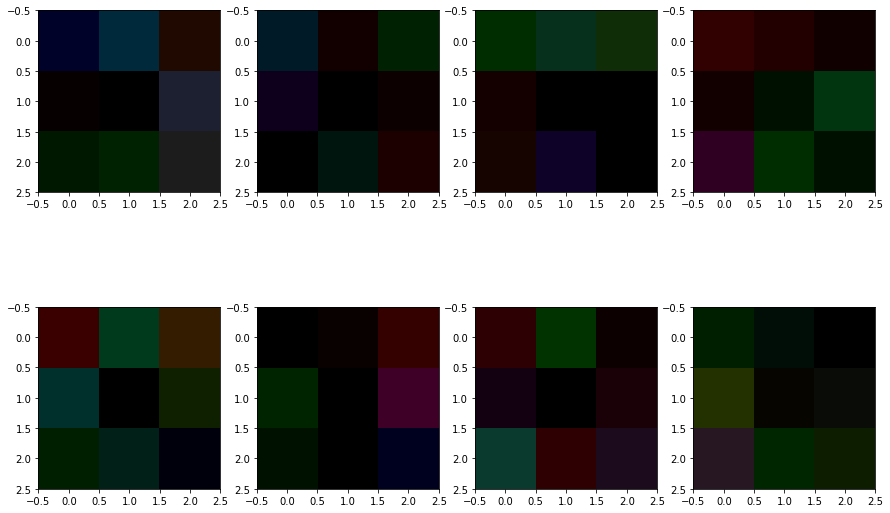

In [ ]:
weight = net.conv1.weight.data.numpy()


fig, axes = plt.subplots(2, 4, figsize = [15, 10])
axes[0,0].imshow(weight[0, ...])
axes[0,1].imshow(weight[1, ...])
axes[0,2].imshow(weight[2, ...])
axes[0,3].imshow(weight[3, ...])
axes[1,0].imshow(weight[4, ...])
axes[1,1].imshow(weight[5, ...])
axes[1,2].imshow(weight[6, ...])
axes[1,3].imshow(weight[7, ...])

## Tuning

version-batchsize-epochnum-lr-error

1-64-20-0.0005-2.11%